In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
# set default matplotlib parameters for better aesthetics
plt.rcParams['figure.figsize'] = (10, 6)
# fontsize
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['lines.linewidth'] = 2

# ============================================================
# SET YOUR DATA PATH HERE
# ============================================================
PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113'
FN = 'date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004'  # without .h5 extension
h5_path = os.path.join(PTH, FN + '.h5')

# Number of z-slices per confocal volume
N_STACK = 41

print(f"Looking for: {h5_path}")
print(f"File exists: {os.path.exists(h5_path)}")

Looking for: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004.h5
File exists: True


In [2]:
def print_h5_structure(h5_path):
    """Recursively print all datasets and groups in an HDF5 file."""
    def visitor(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  {name:40s} shape={str(obj.shape):20s} dtype={obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"  {name}/  (group)")

    with h5py.File(h5_path, 'r') as f:
        print(f"\nHDF5 file structure: {h5_path}\n")
        f.visititems(visitor)
        
        # Key checks
        print("\n--- Key Dataset Info ---")
        if 'img_nir' in f:
            shape = f['img_nir'].shape
            print(f"  img_nir: {shape}  (n_frames={shape[0] if len(shape)==3 else shape[2]})")
        else:
            print("  ⚠ img_nir NOT FOUND")
            
        if 'daqmx_ai' in f:
            print(f"  daqmx_ai: {f['daqmx_ai'].shape}")
        else:
            print("  ⚠ daqmx_ai NOT FOUND")
            
        if 'daqmx_di' in f:
            print(f"  daqmx_di: {f['daqmx_di'].shape}")
        else:
            print("  ⚠ daqmx_di NOT FOUND")
            
        if 'img_metadata' in f:
            for key in f['img_metadata'].keys():
                print(f"  img_metadata/{key}: {f['img_metadata'][key].shape}")
        else:
            print("  ⚠ img_metadata NOT FOUND")

print_h5_structure(h5_path)


HDF5 file structure: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004.h5

  daqmx_ai                                 shape=(3, 2400520)         dtype=float64
  daqmx_di                                 shape=(2, 2400536)         dtype=uint32
  img_metadata/  (group)
  img_metadata/img_id                      shape=(18864,)             dtype=int64
  img_metadata/img_timestamp               shape=(18864,)             dtype=int64
  img_metadata/q_iter_save                 shape=(18864,)             dtype=uint8
  img_metadata/q_recording                 shape=(18864,)             dtype=uint8
  img_nir                                  shape=(9432, 732, 968)     dtype=uint8
  pos_feature                              shape=(9432, 3, 3)         dtype=float32
  pos_stage                                shape=(9432, 2)            dtype=float64
  recording_start                          shape=()                   dtype=|S23

--- Key

In [ ]:
# Quick visualization of the signals used for synchronization
index2plot = (13000,16000) # range of samples to plot (for better visualization, since there are many samples)

lw = 2

with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]

fig, axes = plt.subplots(5, 1, figsize=(16, 14), sharex=True)

labels = [
    ('daqmx_ai col 0', 'Laser Signal', 'orange'),
    ('daqmx_ai col 1', 'Piezo Signal', 'blue'),
    ('daqmx_ai col 2', 'Stimulus Signal', 'magenta'),
    ('daqmx_di col 0', 'Confocal Camera DI', 'green'),
    ('daqmx_di col 1', 'NIR Camera DI', 'red'),
]

# Plot analog inputs
for i in range(3):
    axes[i].plot(daqmx_ai[i, index2plot[0]:index2plot[1]] if daqmx_ai.shape[0] < daqmx_ai.shape[1] else daqmx_ai[index2plot[0]:index2plot[1], i],
                 color=labels[i][2], linewidth=lw)
    axes[i].set_ylabel(labels[i][1])
    axes[i].set_title(labels[i][0])

# Plot digital inputs
for i in range(2):
    axes[i+3].plot(daqmx_di[i, index2plot[0]:index2plot[1]] if daqmx_di.shape[0] < daqmx_di.shape[1] else daqmx_di[index2plot[0]:index2plot[1], i],
                   color=labels[i+3][2], linewidth=lw)
    axes[i+3].set_ylabel(labels[i+3][1])
    axes[i+3].set_title(labels[i+3][0])

axes[-1].set_xlabel('Sample Index')
plt.suptitle('Raw DAQ Signals (used for sync)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\ndaqmx_ai shape: {daqmx_ai.shape}")
print(f"daqmx_di shape: {daqmx_di.shape}")

In [3]:
def filter_ai_laser(ai_laser, di_camera, n_rec=1):
    n_ai, n_di = len(ai_laser), len(di_camera)
    n = min(n_ai, n_di)
    ai_laser_zstack_only = np.array(ai_laser[:n], dtype=np.float32)
    ai_laser_filter_bit = np.zeros(n, dtype=np.float32)
    trg_state = np.zeros(n, dtype=np.float64)

    n_y = n
    n_kernel = 100

    for i in range(n_y):
        start = max(0, i - n_kernel)
        stop = min(n_y, i + n_kernel)
        trg_state[i] = np.max(di_camera[start:stop])

    diff_trg_state = np.diff(trg_state)
    list_idx_start = np.where(diff_trg_state == 1)[0]
    list_idx_end = np.where(diff_trg_state == -1)[0]

    if n_rec > len(list_idx_start):
        raise ValueError("filter_ai_laser: not enough recording detected. check n_rec")
    
    list_idx_rec = np.argsort(list_idx_end - list_idx_start)[::-1][:n_rec]
    for i in list_idx_rec:
        ai_laser_filter_bit[list_idx_start[i]+1:list_idx_end[i]] = 1

    return ai_laser_filter_bit * ai_laser_zstack_only

In [ ]:
def detect_nir_timing(path_h5):
    with h5py.File(path_h5, "r") as h5f:
        n_img_nir = h5f["img_nir"].shape[2]
        daqmx_di = h5f["daqmx_di"][:]
        img_metadata = {key: h5f["img_metadata"][key][()] for key in h5f["img_metadata"]}

    di_nir = daqmx_di[:, 1].astype(np.float32)
    img_timestamp = img_metadata["img_timestamp"]
    img_id = img_metadata["img_id"]
    q_iter_save = img_metadata["q_iter_save"]

    return detect_nir_timing(di_nir, img_id, q_iter_save, n_img_nir)

def detect_confocal_timing(ai_laser):
    # Binarize laser analog signal
    ai_laser_bin = (ai_laser > np.mean(ai_laser)).astype(np.int16)

    list_confocal_on = np.where(np.diff(ai_laser_bin) == 1)[0] + 1
    list_confocal_off = np.where(np.diff(ai_laser_bin) == -1)[0] + 1

    list_stack_start = list_confocal_on[np.where(np.diff(list_confocal_on) > 150)[0] + 1]
    list_stack_start = np.insert(list_stack_start, 0, list_confocal_on[0])  # prepend first element

    list_stack_stop = list_confocal_off[np.where(np.diff(list_confocal_off) > 150)[0]]
    list_stack_stop = np.append(list_stack_stop, list_confocal_off[-1])  # append last element

    if len(list_stack_start) != len(list_stack_stop):
        raise ValueError("n(stack_off_confocal) != n(stack_on_confocal)")

    list_stack_diff = list_stack_stop - list_stack_start
    idx_vol = np.arange(len(list_stack_diff))

    if np.diff(list_stack_diff)[-1] < -3:
        idx_vol = np.arange(len(list_stack_diff) - 1)

    return list_stack_start[idx_vol], list_stack_stop[idx_vol]



In [ ]:
def sync_timing(di_nir, ai_laser, img_id, q_iter_save, n_img_nir):
    timing_stack = np.column_stack(detect_confocal_timing(ai_laser))
    timing_nir = detect_nir_timing(di_nir, img_id, q_iter_save, n_img_nir)

    confocal_to_nir = []
    nir_to_confocal = np.zeros(timing_nir.shape[0], dtype=int)

    for i in range(timing_stack.shape[0]):
        start_, end_ = timing_stack[i, :]

        nir_on_bit = (start_ < timing_nir[:, 0]) & (timing_nir[:, 0] < end_)
        nir_off_bit = (start_ < timing_nir[:, 1]) & (timing_nir[:, 1] < end_)

        idx_ = np.where(nir_on_bit & nir_off_bit)[0]
        confocal_to_nir.append(idx_)

        nir_to_confocal[idx_] = i + 1  # Adjust for 1-based indexing in Julia

    return confocal_to_nir, nir_to_confocal, timing_stack, timing_nir

In [ ]:
def sync_timing(path_h5, n_rec=1):
    with h5py.File(path_h5, 'r') as f:
        daqmx_ai = f['daqmx_ai'][:]
        daqmx_di = f['daqmx_di'][:]
        n_img_nir = f['img_nir'].shape[0]
        img_metadata = f['img_metadata']
        img_timestamp = img_metadata['img_timestamp']
        img_id = img_metadata["img_id"]
        q_iter_save = img_metadata["q_iter_save"]
        
    print(f"Loaded daqmx_ai with shape: {daqmx_ai.shape}")
    print(f"Loaded daqmx_di with shape: {daqmx_di.shape}")
    print(f"Number of NIR images: {n_img_nir}")
    
    ai_laser = filter_ai_laser(daqmx_ai[0,:], daqmx_di[0,:], n_rec)
    ai_piezo = daqmx_ai[1,:]
    ai_stim = daqmx_ai[2,:]
    di_confocal = daqmx_di[0,:].astype(np.float32)
    di_nir = daqmx_di[1,:].astype(np.float32)

    sync_timing_(di_nir, ai_laser, img_id, q_iter_save, n_img_nir)
    
    return ai_laser
    

In [13]:
ai_laser = sync_timing(h5_path, n_rec=1)

Loaded daqmx_ai with shape: (3, 2400520)
Loaded daqmx_di with shape: (2, 2400536)
Number of NIR images: 9432


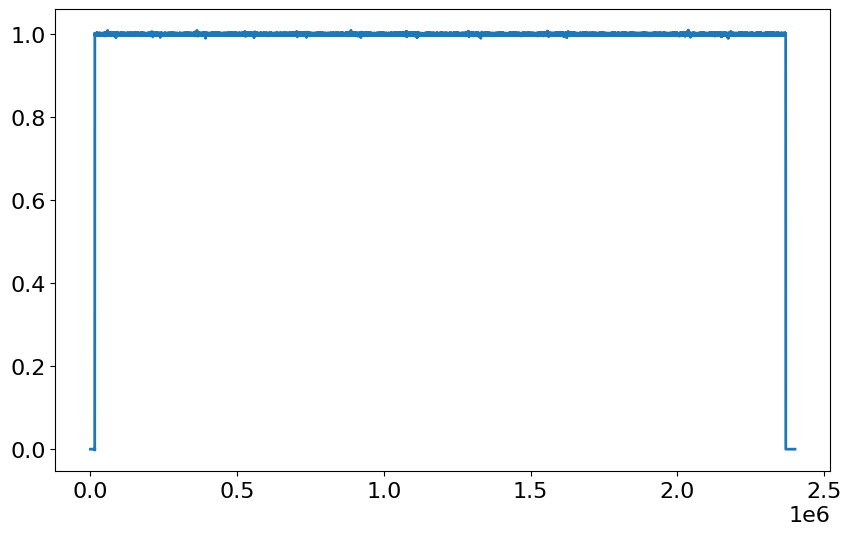

In [14]:
plt.figure()
plt.plot(ai_laser)
plt.show()

In [ ]:
ai_laser, di_camera = daqmx_ai[0,:], daqmx_di[0,:]
n_rec = 1

n_ai, n_di = len(ai_laser), len(di_camera)
n = min(n_ai, n_di)
ai_laser_zstack_only = np.array(ai_laser[:n], dtype=np.float32)
ai_laser_filter_bit = np.zeros(n, dtype=np.float32)
trg_state = np.zeros(n, dtype=np.float64)

n_y = n
n_kernel = 100

for i in range(n_y):
    start = max(0, i - n_kernel)
    stop = min(n_y, i + n_kernel)
    trg_state[i] = np.max(di_camera[start:stop])

diff_trg_state = np.diff(trg_state)
list_idx_start = np.where(diff_trg_state == 1)[0]
list_idx_end = np.where(diff_trg_state == -1)[0]

In [ ]:
list_idx_end

In [ ]:
plt.figure()
plt.plot(diff_trg_state)
plt.show()